### 1. Import Dependencies and Setup

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense ,Input
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.models import load_model

### 2. Load Data 

In [11]:
data_dir = "data/image"
classes = os.listdir(data_dir)
classes

['NORMAL', 'PNEUMONIA']

In [12]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 5856 files belonging to 2 classes.


In [13]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
images, labels = batch
images.shape, labels

((32, 256, 256, 3),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32))

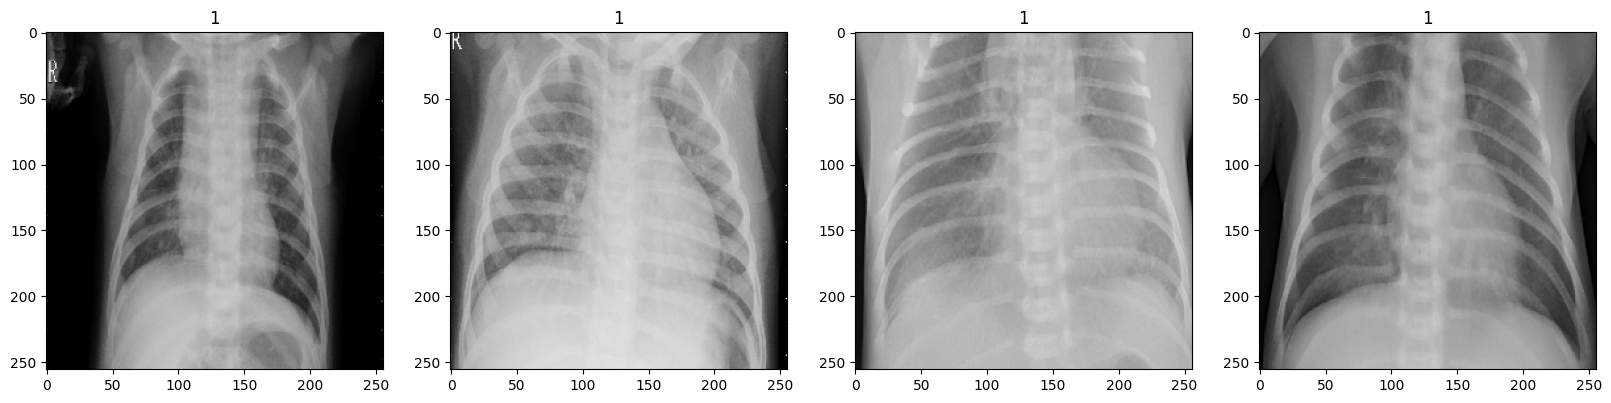

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [15]:
batch[0].min() ,batch[0].max()

(np.float32(0.0), np.float32(255.0))

### 3. Data Preprocessing & Scaling

In [16]:
scaled = batch[0] / 255.0
scaled.min(), scaled.max()

(np.float32(0.0), np.float32(1.0))

In [17]:
data = data.map(lambda x, y: (x / 255.0, y))

In [18]:
scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()
images, labels = batch
images.shape, labels

((32, 256, 256, 3),
 array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 0], dtype=int32))

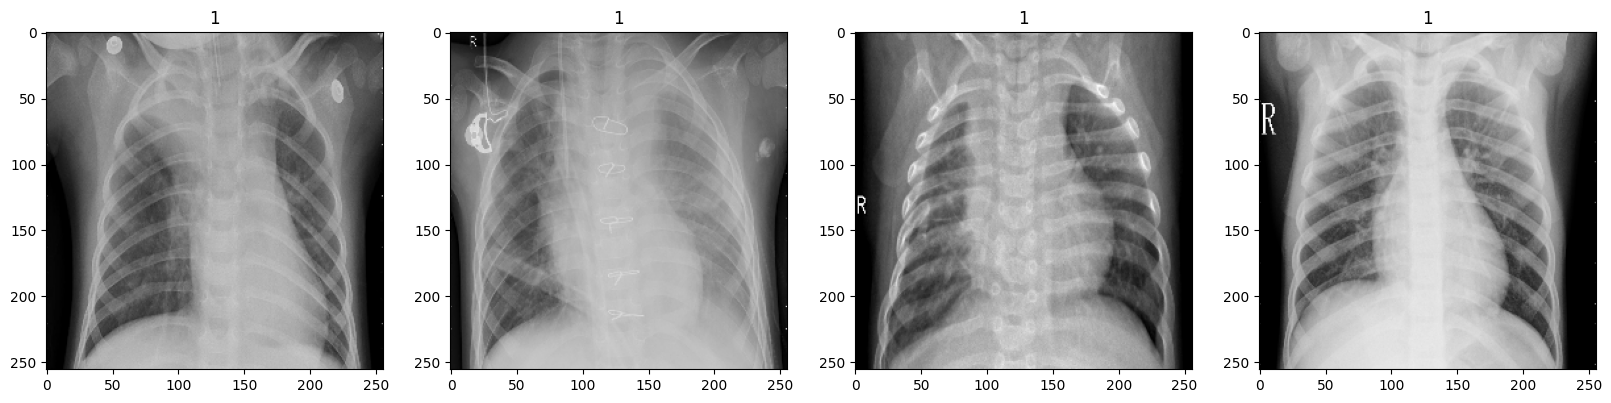

In [19]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

### 4. Splitting Data into Training, Valuating and Testing Sets

In [27]:
data_length = len(data) 

train_size = int(data_length * 0.7) # 128 * 32 = 4096
val_size = int(data_length * 0.2) # 36 * 32 = 1152
test_size = int(data_length * 0.1) # 18 * 32 = 576


print(data_length)
train_size, val_size, test_size

183


(128, 36, 18)

In [28]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

### 5. Model Building

In [29]:
model = Sequential()

In [ ]:
model.add(Input(shape=(256, 256, 3)))  # เพิ่ม Input layer แยกต่างหาก
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [31]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

### 6. Model Training 

In [33]:
logs_dir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logs_dir)

In [34]:
history = model.fit(train, epochs=24, validation_data=val, callbacks=[tensorboard_callback])


Epoch 1/24
128/128 ━━━━━━━━━━━━━━━━━━━━ 22s 154ms/step - accuracy: 0.8186 - loss: 0.4178 - val_accuracy: 0.9253 - val_loss: 0.1883
Epoch 2/24
128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 153ms/step - accuracy: 0.9347 - loss: 0.1584 - val_accuracy: 0.9288 - val_loss: 0.1750
Epoch 3/24
128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 152ms/step - accuracy: 0.9445 - loss: 0.1413 - val_accuracy: 0.9549 - val_loss: 0.1305
Epoch 4/24
128/128 ━━━━━━━━━━━━━━━━━━━━ 19s 152ms/step - accuracy: 0.9596 - loss: 0.1126 - val_accuracy: 0.9462 - val_loss: 0.1394
Epoch 5/24
128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 164ms/step - accuracy: 0.9627 - loss: 0.0977 - val_accuracy: 0.9462 - val_loss: 0.1507
Epoch 6/24
128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 166ms/step - accuracy: 0.9689 - loss: 0.0779 - val_accuracy: 0.9444 - val_loss: 0.1423
Epoch 7/24
128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 158ms/step - accuracy: 0.9703 - loss: 0.0781 - val_accuracy: 0.9227 - val_loss: 0.2075
Epoch 8/24
128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 153ms/step - accuracy: 0.9768 - loss: 0

### 7. Plot Performance

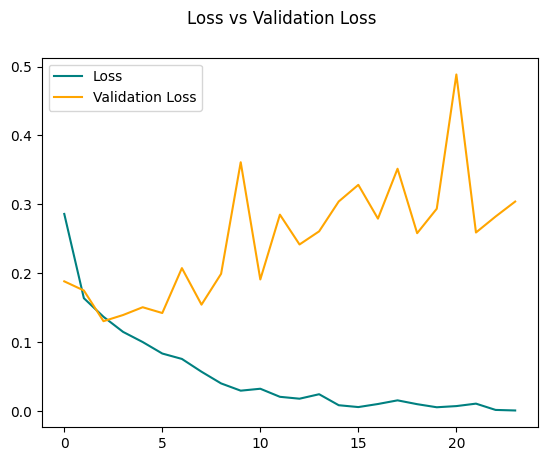

In [35]:
accuracy, val_accuracy = history.history['loss'], history.history['val_loss']

fig = plt.figure()
plt.plot(accuracy, color = 'teal', label='Loss')
plt.plot(val_accuracy, color = 'orange', label='Validation Loss')
fig.suptitle('Loss vs Validation Loss')
plt.legend(loc='upper left')
plt.show()

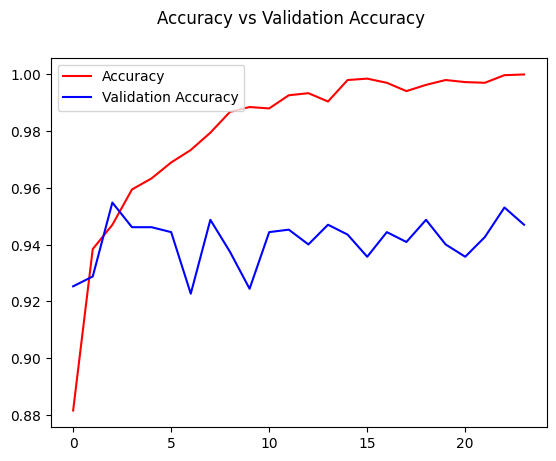

In [36]:
accuracy, val_accuracy = history.history['accuracy'], history.history['val_accuracy']

fig = plt.figure()
plt.plot(accuracy, color = 'red', label='Accuracy')
plt.plot(val_accuracy, color = 'blue', label='Validation Accuracy')
fig.suptitle('Accuracy vs Validation Accuracy')
plt.legend(loc='upper left')
plt.show()

### 8. Model Evaluation

In [37]:
pre = Precision()
rec = Recall()
acc = BinaryAccuracy()

In [38]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    rec.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


In [39]:
print('Precision: ', pre.result().numpy())
print('Recall: ', rec.result().numpy())
print('Accuracy: ', acc.result().numpy())

Precision:  0.9628713
Recall:  0.95110023
Accuracy:  0.9392361


### 9. Testing Model

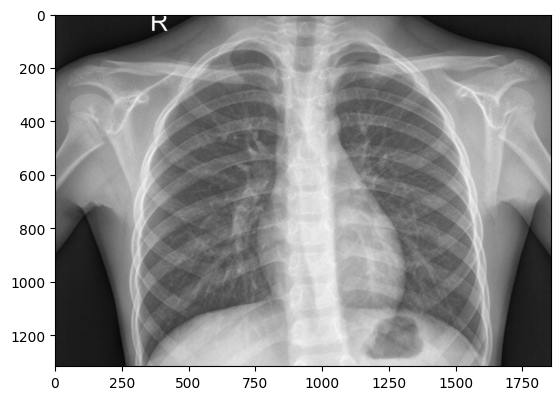

In [42]:
img = cv2.imread('data/image/NORMAL/IM-0001-0001.jpeg')
plt.imshow(img)
plt.show()

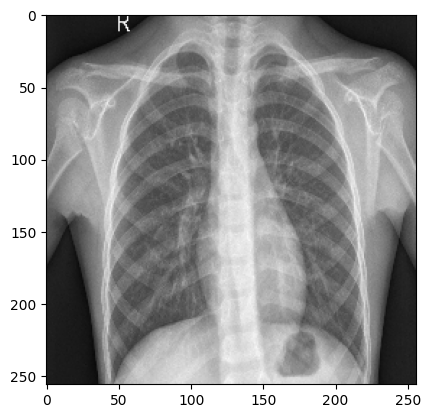

In [43]:
resized = cv2.resize(img, (256, 256))
plt.imshow(resized)
plt.show()

In [44]:
yhat = model.predict(np.array([resized / 255.0]))
yhat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


array([[3.775591e-07]], dtype=float32)

In [45]:
if yhat > 0.5:
    print('Pneumonia')
else:
    print('Normal')

Normal


In [47]:
def predict(img_path):
    img = cv2.imread(img_path)
    resized = cv2.resize(img, (256, 256))
    yhat = model.predict(np.array([resized / 255.0]), verbose=False)
    if yhat > 0.5:
        print('Pneumonia')
    else:
        print('Normal')

predict('data/image/NORMAL/IM-0001-0001.jpeg')
predict('data/image/PNEUMONIA/person1_bacteria_1.jpeg')

Normal
Pneumonia


### 10. Save Model 

In [48]:
model.save('models/main_model.keras')

In [49]:
new_model = load_model('models/main_model.keras')

In [50]:
def predict(img_path):
    img = cv2.imread(img_path)
    resized = cv2.resize(img, (256, 256))
    yhat = new_model.predict(np.array([resized / 255.0]), verbose=False)
    if yhat > 0.5:
        return 'Pneumonia'
    return 'Normal'

predict('data/image/normal/IM-0001-0001.jpeg'), predict('data/image/pneumonia/person1_bacteria_1.jpeg')

('Normal', 'Pneumonia')